Let's try and interpolate over the sine function from `examples/simple_fit.ipynb` with a radial basis function network (RBFN). The sine function is
$$f(x) = a\sin(bx),$$
with $a=2.0$ and $b=0.5$. First, let's import everything we need.

In [1]:
""" SwissFit imports """
from swissfit import fit # SwissFit fitter
from swissfit.optimizers import scipy_basin_hopping # Basin hopping global optimizer
from swissfit.optimizers import scipy_least_squares # Trust region reflective local optimizer
from swissfit.machine_learning import radial_basis # Module for radial basis function network

""" Other imports """
import gvar as gvar # Peter Lepage's GVar library
import numpy as np # NumPy

So that we have something to fit to, let's create an artificial dataset. We do so in the next block.

In [2]:
# Parameters of the sine function & the error
a, b, error = 2.0, 0.5, 0.1

# Actual parameters of the sine function
real_fit_parameters = {'c': [a, b]}

# Real dataset
np.random.seed(0) # Seed random number generator
data = {} # Dictionary to hold data

# Input data
data['x'] = np.linspace(0., 2. * np.pi / b, 20)

# Output data
data['y'] = [
    gvar.gvar(
        np.random.normal(a * np.sin(b * xx), error), # Random mean
        error # Error on mean
    )
    for xx in data['x']
]

Next, let's create a radial basis function network. We do so by first specifying the topology of the RBFN. The following RBFN will have two nodes in its hidden layer. 

In [3]:
network_topology = {
    'lyr1': { # Hidden layer
        'in': 1, 'out': 2, # Dimension of input & output
        'activation': 'exp', # Exponential activation
    },
    'lyr2': { # Output layer
        'in': 2, 'out': 1,
        'activation': 'linear' # Linear activation
    }
}

In `SwissFit`, we create a RBFN by passing the above dictionary to a `RadialBasisFunctionNeuralNetwork` object constructor as follows.

In [4]:
# Create radial basis function network
neural_network = radial_basis.RadialBasisNeuralNetwork(network_topology)

# Initialize radial basis function network parameters
p0 = neural_network.initialize_parameters(initialization = 'zero', p0 = {})

That's it! Now let's define our fit function using the instance of the `RadialBasisFunctioNeuralNetwork` class that we just created.

In [5]:
def fit_fcn(x, p):
    return np.ravel(neural_network.out(x, p))

Now that we have our fit function, let's go ahead and fit. Because the loss landscape is much more complicated than it is in `examples/simple_fit.ipynb`, we will use a global optimizer. Everything else is exactly the same. 

In [6]:
# Basin hopping parameters
niter_success = 200 # Number of iterations with same best fit parameters for basin hopping to "converge"
niter = 10000 # Upper bound on total number of basin hopping iterations
T = 1. # Temperature hyperparameter for basin hopping

# Create SwissFit fit object
fitter = fit.SwissFit(
    udata = data, # Fit data; "data = data" is also acceptable - "udata" means "uncorrelated"
    p0 = p0, # Starting values for parameters,
    fit_fcn = fit_fcn, # Fit function
)

# Create trust region reflective local optimizer from SciPy - fitter will save reference to local_optimizer for basin hopping
local_optimizer = scipy_least_squares.SciPyLeastSquares(fitter = fitter)

# Basin hopping global optimizer object instantiation
global_optimizer = scipy_basin_hopping.BasinHopping(
    fitter = fitter, # Fit function is the "calculate_residual" method of fitter object
    optimizer_arguments = {
        'niter_success': niter_success,
        'niter': niter,
        'T': T
    }
)

Let's fit!

In [7]:
# Do fit
fitter(global_optimizer)

# Print result of fit
print(fitter)

# Save fit parameters
fit_parameters = fitter.p


SwissFit: 🧀
   chi2/dof [dof] = 0.73 [13]   Q = 0.74   (Bayes) 
   chi2/dof [dof] = 0.73 [13]   Q = 0.74   (freq.) 
   AIC [k] = 23.44 [7]   logML = 8.846*

Parameters*:
     lyr1.center
             1                  14.0(1.5)   [n/a]
             2                  3.074(42)   [n/a]
     lyr1.bandwidth
             1                   0.09(10)   [n/a]
             2                 -0.047(19)   [n/a]
     lyr2.weight
             1                   3.8(2.5)   [n/a]
             2                   5.4(1.7)   [n/a]
     lyr2.bias
             1                  -3.3(1.7)   [n/a]

Estimator:
   algorithm = SciPy basin hopping
   minimization_failures = 9
   nfev = 22139
   njev = 18175
   fun = 4.720701592800511
   message = ['success condition satisfied']
   nit = 510
   success = True

*Laplace approximation



Why don't we try and see what our fit looks like?

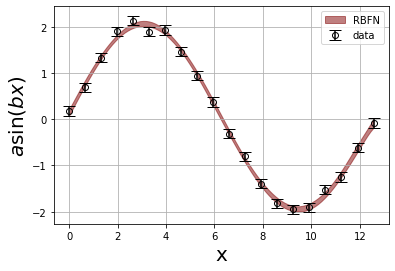

In [8]:
# Import Matplotlib
import matplotlib.pyplot as plt

# Plot fit data
plt.errorbar(
    data['x'], 
    gvar.mean(data['y']), 
    gvar.sdev(data['y']), 
    color = 'k', markerfacecolor = 'none',
    markeredgecolor = 'k',
    capsize = 6., fmt = 'o',
    label = 'data'
)

# Get result of fit function
x = np.linspace(data['x'][0], data['x'][-1], 100)
y = fit_fcn(x, fit_parameters)

# Plot error of fit function from fit as a colored band
plt.fill_between(
    x,
    gvar.mean(y) - gvar.sdev(y),
    gvar.mean(y) + gvar.sdev(y),
    color = 'maroon', alpha = 0.5,
    label = 'RBFN'
)

# x/y label
plt.xlabel('x', fontsize = 20.)
plt.ylabel('$a\\sin(bx)$', fontsize = 20.)

# Show legend
plt.legend()

# Grid
plt.grid('on')